# Model Fit with Least Squares

Let's first just simulate a cartpole, and fit back to that (with noise) to see if everything checks out.

### Equations of motion:

$$
\begin{align*}\left[ \begin{array}{cc}
m_c + m_p & m_p \ell_p\sin(\theta) \\
m_p \ell_p \sin(\theta) & m_p \ell_p^2
\end{array} \right]
\left( \begin{array}{c}
\ddot{x} \\ \ddot{\theta} 
\end{array}\right)
+
\left(\begin{array}{c}
m_p \ell_p \cos(\theta) \dot{\theta}^2 \\ - m_p g \ell_p \sin(\theta)
\end{array}\right)
=
\left(\begin{array}{c}
-k_c x \\
0
\end{array}\right)\end{align*}
$$
So let's set up functions for this.

In [6]:
import numpy as np

def mass_matrix(params, x):
    M = np.zeros((2, 2))
    M[0, 0] = params["mass_cart"] + params["mass_pendulum"]
    M[0, 1] = params["mass_pendulum"] * params["length_pendulum"] * np.sin(x[1])
    M[1, 0] = params["mass_pendulum"] * params["length_pendulum"] * np.sin(x[1])
    M[1, 1] = params["mass_pendulum"] * params["length_pendulum"]**2
    return M


def coriolis(params, x, qDot=None):
    # hacky: we're assuming x input if qDot is None, and (q, qDot) otherwise.
    C = np.zeros(2)
    if qDot is None:
        C[0] = params["mass_pendulum"] * params["length_pendulum"] * np.cos(x[1]) * x[3] ** 2
        C[1] = - params["mass_pendulum"] * params["gravity"] * params["length_pendulum"] * np.sin(x[1])
    else:
        C[0] = params["mass_pendulum"] * params["length_pendulum"] * np.cos(x[1]) * qDot[1] ** 2
        C[1] = - params["mass_pendulum"] * params["gravity"] * params["length_pendulum"] * np.sin(x[1])
    return C

def forces(params, x):
    F = np.zeros(2)
    F[0] = - params["spring_cart"] * x[0]
    return F

Let's do a simple simulation and plot it

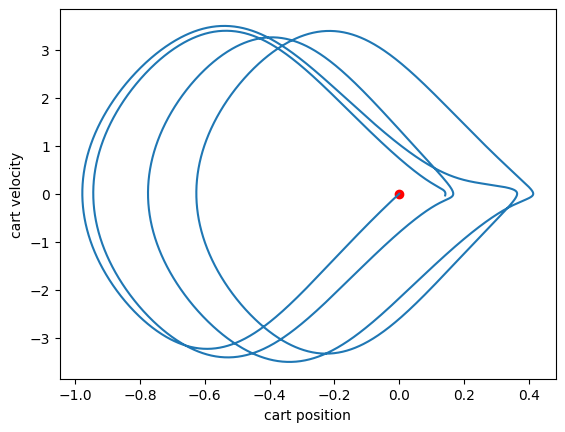

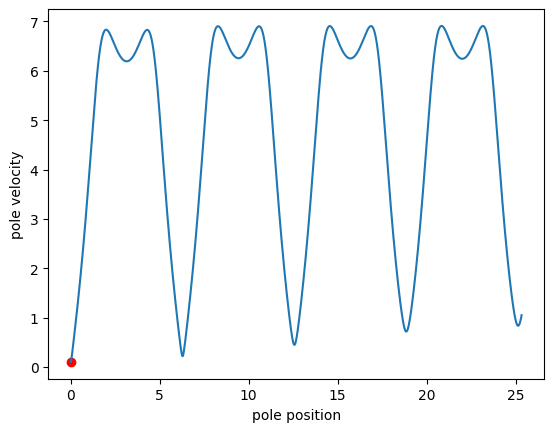

In [7]:
import matplotlib.pyplot as plt

def euler_forward(params, x):
    M = mass_matrix(params, x)
    C = coriolis(params, x)
    F = forces(params, x)
    acceleration = np.linalg.lstsq(M, F - C, rcond=None)[0]
    # or 
    # acceleration = np.matmul(np.linalg.pinv(M), (F - C))
    return x + np.concatenate((x[2:], acceleration))*dt

x = np.array([0, 0, 0, 0.1])

params = {"mass_cart": 1,
          "mass_pendulum": 1,
          "length_pendulum": 1,
          "spring_cart": 1,
          "gravity": 9.81}

dt = 0.001
sim_time = 10

timesteps = int(sim_time/dt)

x_trajectory = np.zeros((timesteps, 4))

for i in range(timesteps):
    x = euler_forward(params, x)
    x_trajectory[i, :] = x

plt.figure(1)
plt.plot(x_trajectory[:, 0], x_trajectory[:, 2])
plt.scatter(x_trajectory[0, 0], x_trajectory[0, 2], c="r")
plt.xlabel("cart position")
plt.ylabel("cart velocity")
plt.figure(2)
plt.plot(x_trajectory[:, 1], x_trajectory[:, 3])
plt.scatter(x_trajectory[0, 1], x_trajectory[0, 3], c="r")
plt.xlabel("pole position")
plt.ylabel("pole velocity")
plt.show()

Let's do a little sanity check. The total energy should stay constant, since it's a conservative system.

-0.035802428981908226

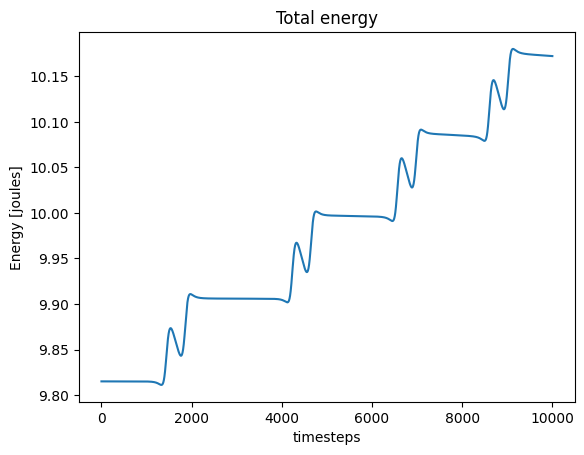

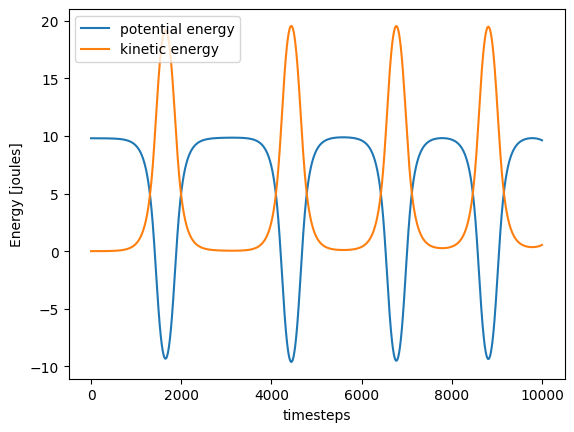

In [8]:
def potential_energy(params, x):
    spring_energy = 0.5 * params["spring_cart"] * x[0]**2
    gravitational_energy = (params["mass_pendulum"] * params["gravity"]
                            * params["length_pendulum"] * np.cos(x[1]))
    return spring_energy + gravitational_energy

def kinetic_energy(params, x):
    cart_energy = params["mass_cart"]/2. * x[2]**2
    pendulum_energy = (params["mass_pendulum"]/2.
                       * ((params["length_pendulum"] * x[3])**2
                          + x[2]**2
                          + 2*params["length_pendulum"]*x[2]*x[3]*np.sin(x[1])))
    return cart_energy + pendulum_energy

potential = np.zeros(timesteps)
kinetic = np.zeros(timesteps)
for i in range(timesteps):
    potential[i] = potential_energy(params, x_trajectory[i, :])
    kinetic[i] = kinetic_energy(params, x_trajectory[i, :])

energy_traj = potential + kinetic
plt.figure(1)
plt.plot(energy_traj)
plt.xlabel('timesteps')
plt.ylabel('Energy [joules]')
plt.title('Total energy')
plt.figure(2)
plt.plot(potential)
plt.plot(kinetic)
plt.xlabel('timesteps')
plt.ylabel('Energy [joules]')
plt.legend(['potential energy', 'kinetic energy'])
(energy_traj[0] - energy_traj[-1])/energy_traj.mean()

Okay, that's not great... but it seems like this may be a python not being very accurate issue... let's continue for now, but we probably either want to use scipy's integrator, or implement RK4 or at least backwards Euler.

## Fitting a feedback controller
Let's assume we know (roughly) the system parameters, in addition to having a recording of the states. But we don't know the feedback controller. Let's try to fit a linear state-feedback controller of the form:

$$
F(q, \dot{q}) = S \cdot K \cdot
\left(\begin{array}{c}
q \\
\dot{q}
\end{array}\right)
$$

where $S$ is the selection matrix and $K$ is a feedback matrix.


For our cartpole, assuming we still have only control at the base (and instead of the spring). So we have

$$
\begin{align*}\left[ \begin{array}{cc}
m_c + m_p & m_p \ell_p\sin(\theta) \\
m_p \ell_p \sin(\theta) & m_p \ell_p^2
\end{array} \right]
\left( \begin{array}{c}
\ddot{x} \\ \ddot{\theta} 
\end{array}\right)
+
\left(\begin{array}{c}
m_p \ell_p \cos(\theta) \dot{\theta}^2 \\ - m_p g \ell_p \sin(\theta)
\end{array}\right)
& =
S \cdot K \cdot
\left(\begin{array}{c}
q \\
\dot{q}
\end{array}\right) \\
& =
\left(\begin{array}{cc}
1 & 0 \\
0 & 0
\end{array}\right)
\cdot
\left(\begin{array}{cccc}
k_{11} & k_{12} & k_{13} & k_{14} \\
k_{21} & k_{22} & k_{23} & k_{24}
\end{array}\right)
\cdot
\left(\begin{array}{c}
x \\ \theta \\
\dot{x} \\ \dot{\theta}
\end{array}\right)
\\
& =
\left(\begin{array}{cccc}
k_{11} & k_{12} & k_{13} & k_{14} \\
0 & 0 & 0 & 0
\end{array}\right)
\cdot
\left(\begin{array}{c}
x \\ \theta \\
\dot{x} \\ \dot{\theta}
\end{array}\right)
\end{align*}
$$


Well, this looks like we can just solve for the first line.....

Also, we need to bring this into a least squares form, so `A@x = b`. Here `b` would be our dynamics (but just the $\ddot{x}$ part), and `A` would be the kinematics.

In [16]:
n_samples = 100
accelerations = np.diff(x_trajectory[:, 2:], axis=0)/dt
q = x_trajectory[:n_samples, :2]
qDot = x_trajectory[:n_samples, 2:]
qDotDot = accelerations[:n_samples, :]

def inertial_and_coriolis_forces(params, q, qDot, qDotDot):
    f = mass_matrix(params, q)@qDotDot + coriolis(params, q, qDot)
    return f[0]

num_datapoints = q.shape[0]
b = np.zeros((num_datapoints, 1))
A = np.zeros((num_datapoints, 4))
for index in range(num_datapoints):
    A[index, :] = np.concatenate((q[index, :], qDot[index, :]))
    b[index, :] = inertial_and_coriolis_forces(params, q[index, :], qDot[index, :], qDotDot[index, :])
    
K, residuals, rank, singular_values = np.linalg.lstsq(A, b, rcond=None)

print(f"Feedback gains: {K.T}")
print(f"residuals: {residuals}")
print(f"rank: {rank}")
print(f"singular_values: {singular_values}")

Feedback gains: [[-1.00000000e+00 -1.15177161e-13 -2.23084232e-12  6.03389758e-17]]
residuals: [1.22422795e-31]
rank: 4
singular_values: [1.01783872e+00 2.85712708e-02 3.37714940e-05 2.55775186e-06]


Let's try using incorrect estimates for parameters

In [18]:
wrong_params = {"mass_cart": 1.1,
                "mass_pendulum": 0.9,
                "length_pendulum": 1.1,
                "gravity": 9.81}

b2 = np.zeros((num_datapoints, 1))
A2 = np.zeros((num_datapoints, 4))
for index in range(num_datapoints):
    A2[index, :] = np.concatenate((q[index, :],
                                        qDot[index, :]))
    b2[index, :] = inertial_and_coriolis_forces(wrong_params, q[index, :], qDot[index, :], qDotDot[index, :])

K2, residuals2, rank2, singular_values2 = np.linalg.lstsq(A2, b2, rcond=None)

print(f"Feedback gains: {K2.T}")

Feedback gains: [[-2.99293853e+00 -1.85015947e-03 -3.79413522e-02  3.49993075e-03]]


Well that isn't too good, there is quite some sensitivity to parameter estimates (although we are 10% off here, so quite inaccurate). We'll need to be careful about that.